1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
#from sklift.viz import plot_uplift_preds 
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier

from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


In [2]:
path = 'uplift_modeling_data_hw4.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
from sklearn.utils.validation import check_consistent_length
import matplotlib.pyplot as plt


def plot_uplift_preds_(trmnt_preds, ctrl_preds, log=False, bins=100):
    """Plot histograms of treatment, control and uplift predictions.

    Args:
        trmnt_preds (1d array-like): Predictions for all observations if they are treatment.
        ctrl_preds (1d array-like): Predictions for all observations if they are control.
        log (bool): Logarithm of source samples. Default is False.
        bins (integer or sequence): Number of histogram bins to be used. Default is 100.
            If an integer is given, bins + 1 bin edges are calculated and returned.
            If bins is a sequence, gives bin edges, including left edge of first bin and right edge of last bin.
            In this case, bins is returned unmodified. Default is 100.

    Returns:
        Object that stores computed values.
    """

    # TODO: Add k as parameter: vertical line on plots
    check_consistent_length(trmnt_preds, ctrl_preds)
  
    if not isinstance(bins, int) or bins <= 0:
        raise ValueError(
            f'Bins should be positive integer. Invalid value for bins: {bins}')

    if log:
        trmnt_preds = np.log(trmnt_preds + 1)
        ctrl_preds = np.log(ctrl_preds + 1)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 7))
    axes[0].hist(
        trmnt_preds, bins=bins, alpha=0.3, color='b', label='Treated', histtype='stepfilled')
    axes[0].set_ylabel('Probability hist')
    axes[0].legend()
    axes[0].set_title('Treatment predictions')

    axes[1].hist(
        ctrl_preds, bins=bins, alpha=0.5, color='y', label='Not treated', histtype='stepfilled')
    axes[1].legend()
    axes[1].set_title('Control predictions')

    axes[2].hist(
        trmnt_preds - ctrl_preds, bins=bins, alpha=0.5, color='green', label='Uplift', histtype='stepfilled')
    axes[2].legend()
    axes[2].set_title('Uplift predictions')

    return axes

In [5]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [6]:
df = df.rename(columns={"offer": "treatment", "conversion": "target"})
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [7]:
df.loc[df['treatment']!='No Offer', 'treatment']=1
df.loc[df['treatment']=='No Offer', 'treatment']=0
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [8]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [9]:
model_results={}

num_cat_features = ['used_discount', 'used_bogo', 'is_referral']
str_cat_features = ['zip_code', 'channel']
cat_features = num_cat_features + str_cat_features

X = df.loc[:, df.columns.difference(['target', 'treatment'])]
t = df.loc[:, 'treatment']
y = df.loc[:, 'target']
X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(X, t, y, test_size=0.3, random_state=123)


,uplift
decile,
0,0.022459
1,0.029856
2,0.034885
3,0.046279
4,0.055993
5,0.063225
6,0.069248
7,0.076477
8,0.083713


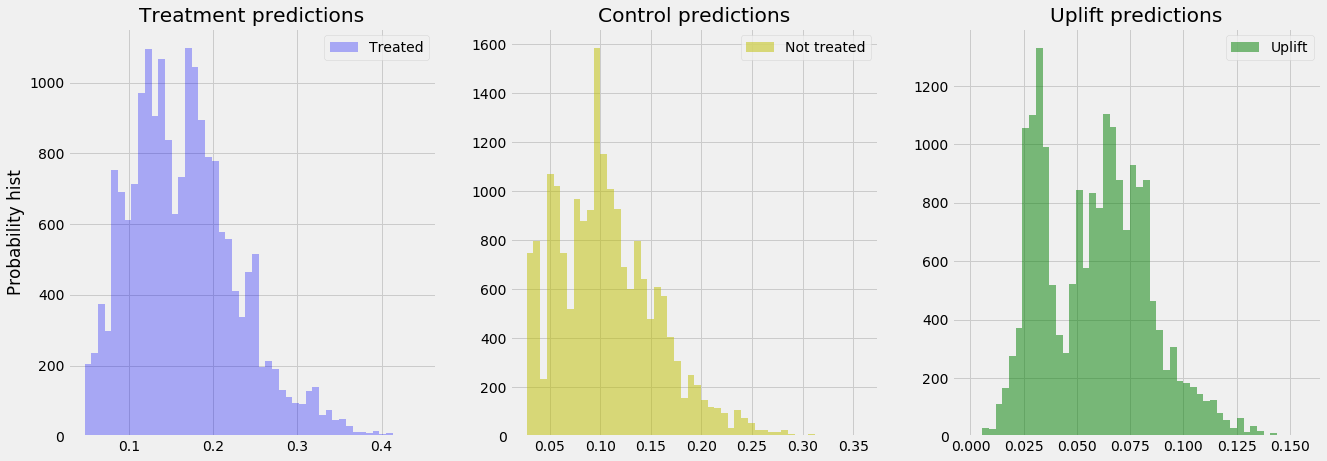

In [10]:
m = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
m.fit(X_train, y_train, t_train, estimator_fit_params={'cat_features': cat_features})

uplift = m.predict(X_test)

model_results['SoloModel'] = [uplift_at_k(y_true=y_test, uplift=uplift, treatment=t_test, strategy='by_group', k=k) for k in (0.1, 0.2, 0.3)]

plot_uplift_preds_(m.trmnt_preds_, m.ctrl_preds_, bins=50);

# задание 8
#uplift = np.sort(uplift)[::-1] # не влияет на результат
pd.DataFrame({'uplift': uplift, 'decile': pd.qcut(uplift, 10, labels=False)}).groupby('decile').mean()

In [11]:
m = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
m.fit(X_train, y_train, t_train, estimator_fit_params={'cat_features': cat_features})

uplift = m.predict(X_test)

model_results['ClassTransformation'] = [uplift_at_k(y_true=y_test, uplift=uplift, treatment=t_test, strategy='by_group', k=k) for k in (0.1, 0.2, 0.3)]

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


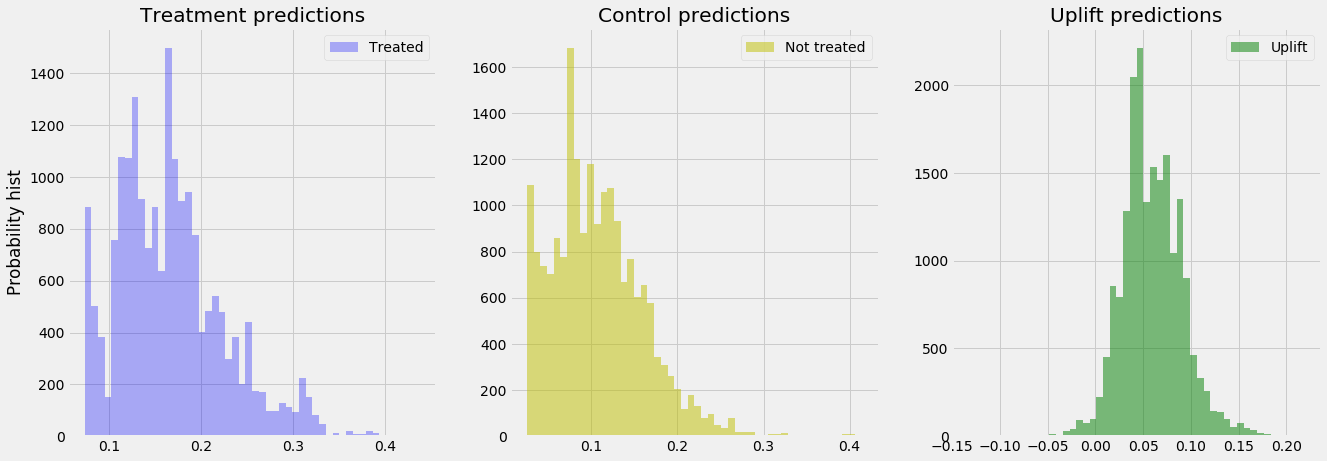

In [12]:
m = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
m.fit(
    X_train, y_train, t_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift = m.predict(X_test)

model_results['TwoModels'] = [uplift_at_k(y_true=y_test, uplift=uplift, treatment=t_test, strategy='by_group', k=k) for k in (0.1, 0.2, 0.3)]
plot_uplift_preds_(m.trmnt_preds_, m.ctrl_preds_, bins=50);

In [13]:
pd.DataFrame.from_dict(data=model_results, orient='index', columns=['uplift@10%', 'uplift@20%', 'uplift@30%']).sort_values(by='uplift@10%', ascending=False)

,uplift@10%,uplift@20%,uplift@30%
ClassTransformation,0.108803,0.098534,0.090554
TwoModels,0.091585,0.077031,0.080101
SoloModel,0.090030,0.084072,0.087420


In [14]:
X_train_tree, X_test_tree = [pd.concat([x.drop(str_cat_features, 1)] + [pd.get_dummies(x[c], prefix=c) for c in str_cat_features], 1) for x in (X_train, X_test)]

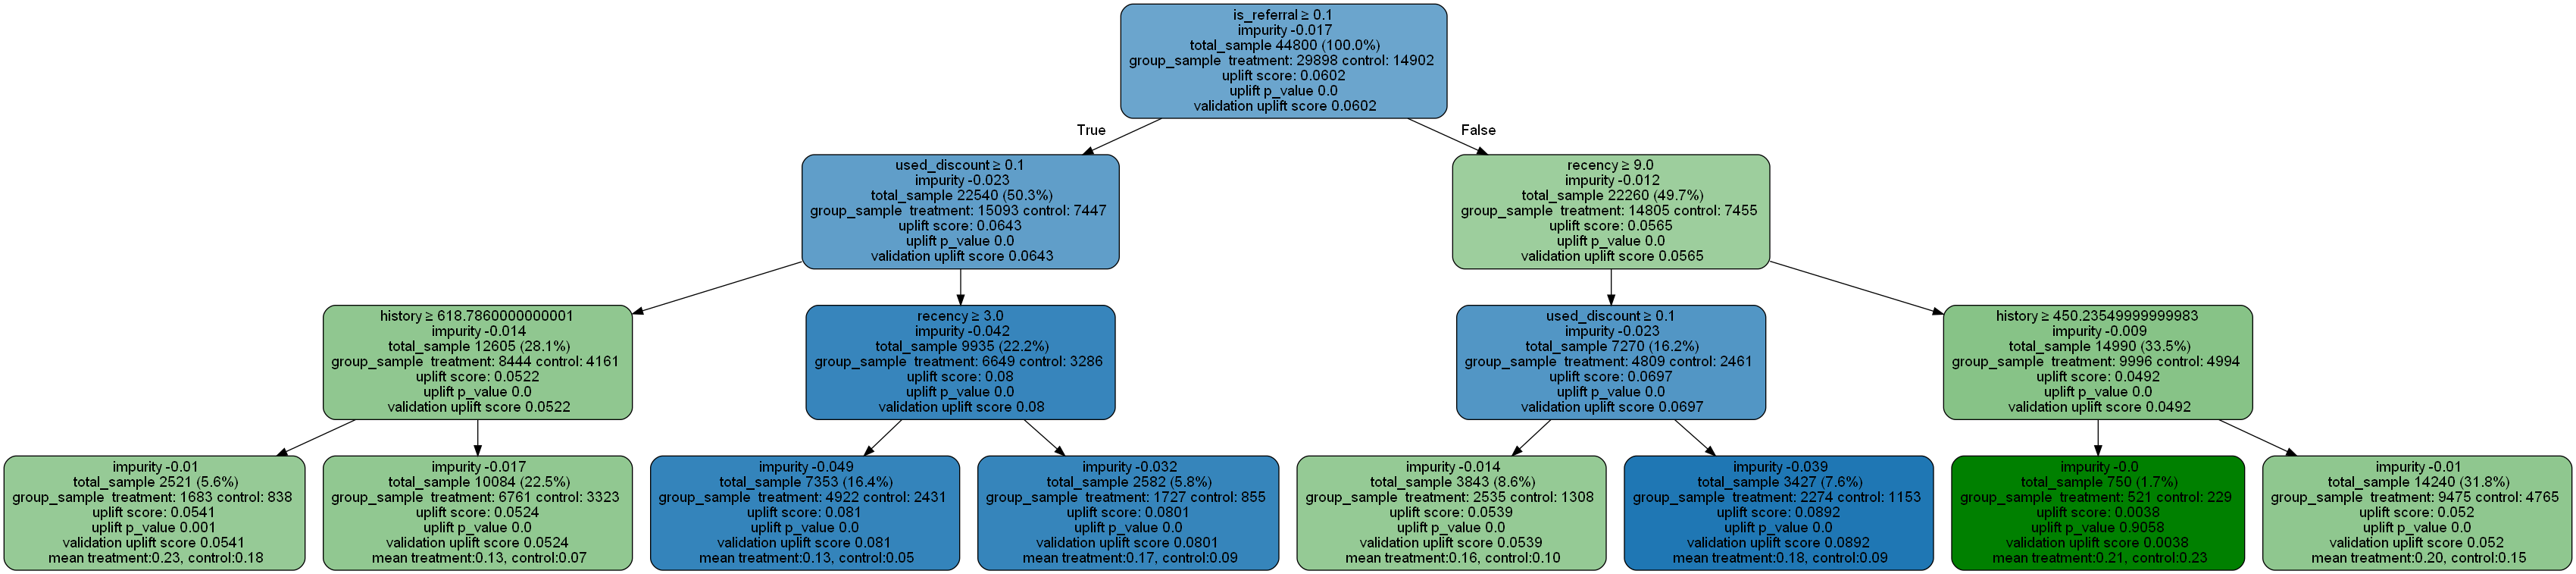

Wall time: 1.21 s


In [15]:
%%time

m = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

m.fit(X_train_tree.values, treatment=t_train.map({1: 'treatment', 0: 'control'}).values, y=y_train.values)

graph = uplift_tree_plot(m.fitted_uplift_tree, list(X_test_tree))
display(Image(graph.create_png()))

Интерпретация дерева: 
Предполагаю, что все левые стрелки - True, правые - False. Проследим до одного из листьев:
is_referral >= 0.1 (был скорее получен по рекомендации), used_discount < 0.1 (скорее не пользовался скидками) имеет сравнительно высокий uplift score 0.08, с очень высокой степенью уверенности: p-value = 0, фактически не зависит от recency: 0.13 в обработанной группе против 0.05 в контрольной (или 0.17 против 0.09) . То есть, скорее всего будет польза от работы с таким клиентом. 

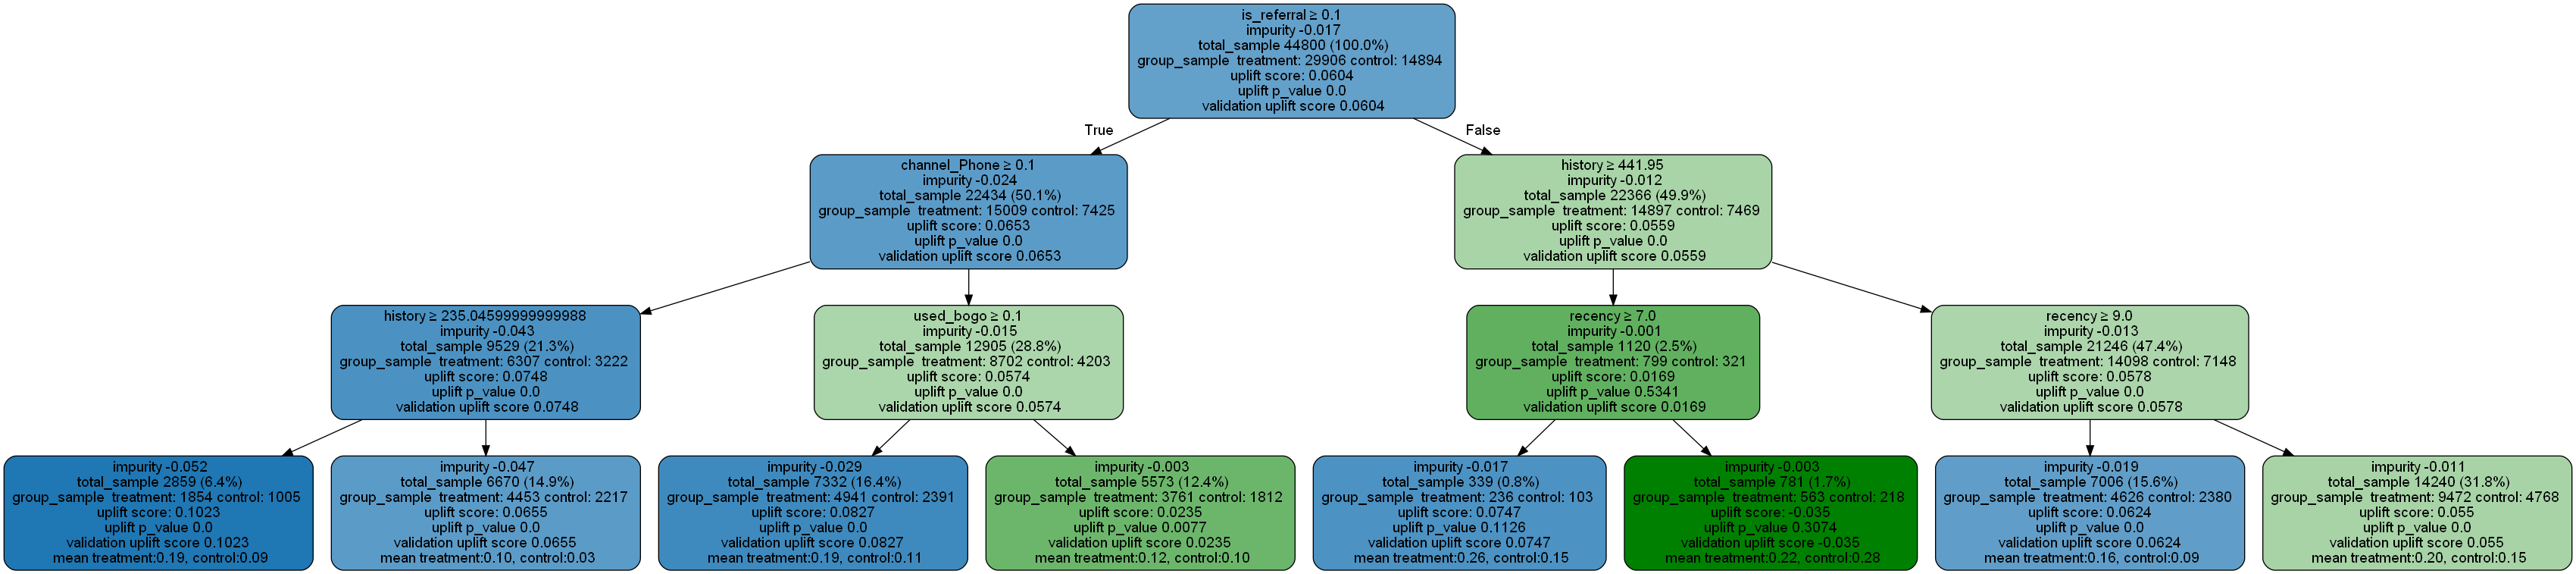

Wall time: 7.62 s


In [16]:
%%time

m = UpliftRandomForestClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

m.fit(X_train_tree.values, treatment=t_train.map({1: 'treatment', 0: 'control'}).values, y=y_train.values)
tree = m.uplift_forest[0]
graph = uplift_tree_plot(tree.fitted_uplift_tree, list(X_test_tree))
display(Image(graph.create_png()))

Интерпретация одного из деревьев леса: 
Предполагаю, что все левые стрелки - True, правые - False. Проследим до одного из листьев:
used_discount < 0.1 (скорее не пользовался скидками) и is_referral >= 0.1 (клиент был скорее получен по рекомендации), имеет сравнительно высокий uplift score 0.09, с очень высокой степенью уверенности: p-value = 0, фактически не зависит от history. В случае же is_referral < 0.1 (был скорее получен без рекомендаций) uplift все тоже довольно высокий (и с очень высокой уверенностью), но зависит от давности последней покупки: если давно не покупал (recency >=9.0), то 0.09, иначе 0.05 